In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import FourierBasis
from skfda.preprocessing.smoothing import BasisSmoother
import glob
import re 
from skfda.misc.metrics import l2_distance
from tqdm import tqdm
import random

## Loading All Data

In [3]:
# Get all csv files in the folder
folder_path = 'Aligned Data All Participants'

# Initialize separate dictionaries
ax_series = []
la_series = []
fl_series = []

# Get all CSV files
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

def truncate(arr, decimals=0):
    factor = 10.0 ** decimals
    return np.trunc(arr * factor) / factor

def FDtuple(df_imu, df_mcp):
    if not df_imu.empty and not df_mcp.empty:
        time_imu = truncate(df_imu.iloc[:, 0].values, 3)
        meas_imu = df_imu.iloc[:, 1].values
        time_mcp = truncate(df_mcp.iloc[:, 0].values, 3) 
        meas_mcp = df_mcp.iloc[:, 1].values

        t_min = min(time_imu.min(), time_mcp.min())
        t_max = max(time_imu.max(), time_mcp.max())
        domain = (t_min, t_max)

        return tuple([
            FDataGrid([meas_imu], grid_points=[time_imu], domain_range=domain),
            FDataGrid([meas_mcp], grid_points=[time_mcp], domain_range=domain)
        ])
    else:
        return None


for i in range(1, 31): 

    ax_imu = pd.DataFrame()
    ax_mcp = pd.DataFrame()
    la_imu = pd.DataFrame()
    la_mcp = pd.DataFrame()
    fl_imu = pd.DataFrame()
    fl_mcp = pd.DataFrame()

    for file in all_files:
        
        if re.search(rf'\\{i}(?!\d)', file):  
            if 'Axial' in file and 'IMU' in file: 
                ax_imu = pd.read_csv(file)
            elif 'Axial' in file and 'MoCap' in file:
                ax_mcp = pd.read_csv(file)
            elif 'Lateral' in file and 'IMU' in file:
                la_imu = pd.read_csv(file)
            elif 'Lateral' in file and 'MoCap' in file:
                la_mcp = pd.read_csv(file)
            elif 'Flexion' in file and 'IMU' in file:
                fl_imu = pd.read_csv(file)
            elif 'Flexion' in file and 'MoCap' in file:
                fl_mcp = pd.read_csv(file)
            else: 
                print('Warning: {file} isnt classified')
    
    if (ax := FDtuple(ax_imu, ax_mcp)):
        ax_series.append(ax)

    if (la := FDtuple(la_imu, la_mcp)):
        la_series.append(la)

    if (fl := FDtuple(fl_imu, fl_mcp)):
        fl_series.append(fl)

print(f"Loaded {len(ax_series)} AxialRotation participants, each with MCP and IMU measurements.")
print(f"Loaded {len(la_series)} Flexion participants, each with MCP and IMU measurements.")
print(f"Loaded {len(fl_series)} LateralBending participants, each with MCP and IMU measurements.")

Loaded 26 AxialRotation participants, each with MCP and IMU measurements.
Loaded 27 Flexion participants, each with MCP and IMU measurements.
Loaded 28 LateralBending participants, each with MCP and IMU measurements.


## Distances in Axial Rotations + Statistical Test

In [7]:
basis = FourierBasis(domain_range=(0, 1), n_basis=7)
smoother = BasisSmoother(basis=basis)

def smooth_fd(fd1: FDataGrid, fd2: FDataGrid):
    t_min = max(fd1.grid_points[0].min(), fd2.grid_points[0].min())
    t_max = min(fd1.grid_points[0].min(), fd2.grid_points[0].max()) 
    grid = np.linspace(t_min, t_max)
    return smoother.fit_transform(fd1.to_grid(grid)), smoother.fit_transform(fd2.to_grid(grid))

smoothed_pairs = []
for s1, s2 in ax_series:
    smoothed_s1, smoothed_s2 = smooth_fd(s1, s2) 
    smoothed_pairs.append((smoothed_s1, smoothed_s2))

c:\Users\telec\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\axes\_axes.py:7096: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\telec\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\axes\_axes.py:7097: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


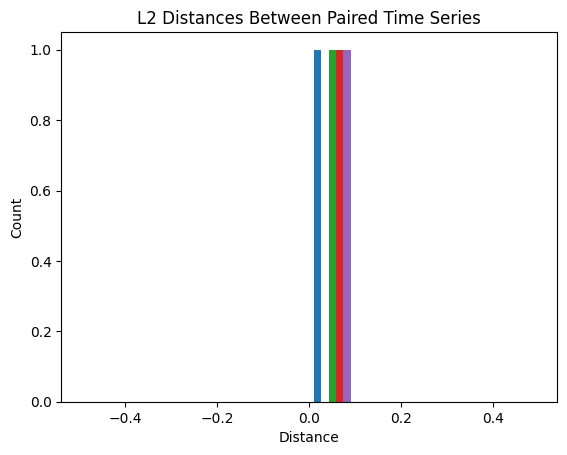

In [6]:
# Compute L2 distance for each participant's two smoothed series
distances = []
for s1, s2 in smoothed_pairs:
    d = l2_distance(s1, s2)
    distances.append(d)

# Visualize distances
plt.hist(distances, bins=10)
plt.title("L2 Distances Between Paired Time Series")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.show()

In [ ]:
all_series = [s for pair in smoothed_pairs for s in pair]

n_permutations = 1000
permuted_averages = []

for _ in tqdm(range(n_permutations)):
    shuffled = random.sample(all_series, len(all_series))
    permuted_pairs = [(shuffled[i], shuffled[i+1]) for i in range(0, len(shuffled), 2)]
    dists = [l2_distance(s1, s2) for s1, s2 in permuted_pairs]
    permuted_averages.append(np.mean(dists))

100%|██████████| 1000/1000 [00:10<00:00, 95.86it/s]


In [ ]:
permuted_averages = np.array(permuted_averages)
p_value = np.mean(permuted_averages <= observed_avg)  # one-sided test
print(f"P-value: {p_value:.4f}")

# Plot the permutation distribution
plt.hist(permuted_averages, bins=30, color='lightgray', edgecolor='black')
plt.axvline(observed_avg, color='red', linestyle='--', label=f'Observed Avg = {observed_avg:.3f}')
plt.title("Permutation Test: Avg L2 Distance of Random vs True Pairs")
plt.xlabel("Average L2 Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()
